# 2. EDA and Preprocessing
This notebook performs exploratory data analysis and cleaning on the synthetic sales data.

In [1]:
import pandas as pd, numpy as np
sales = pd.read_csv('../data/synthetic_sales.csv', parse_dates=['date'])
meta = pd.read_csv('../data/sku_metadata.csv')

In [2]:
# Data cleaning
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.sort_values(['sku_id','date']).reset_index(drop=True)
all_dates = pd.date_range(sales['date'].min(), sales['date'].max())
full = []
for sku in sales['sku_id'].unique():
    tmp = sales[sales['sku_id']==sku].set_index('date').reindex(all_dates).rename_axis('date').reset_index()
    tmp['sku_id'] = sku
    tmp['units_sold'] = tmp['units_sold'].fillna(0).astype(int)
    tmp['price'] = tmp['price'].fillna(method='ffill').fillna(0)
    tmp['on_promo'] = tmp['on_promo'].fillna(0).astype(int)
    tmp['views'] = tmp['views'].fillna(0).astype(int)
    full.append(tmp)
sales_full = pd.concat(full, ignore_index=True)
sales_full['units_sold'] = sales_full['units_sold'].clip(lower=0)
sales_full['views'] = sales_full['views'].clip(lower=0)
sales_full['price'] = sales_full['price'].clip(lower=0)

In [3]:
# Per SKU stats
grouped = sales_full.groupby('sku_id')['units_sold']
summary = grouped.agg(['mean','std']).rename(columns={'mean':'mean_daily','std':'std_daily'}).reset_index()
summary['cv'] = summary['std_daily'] / summary['mean_daily']
summary['pct_zero_days'] = sales_full.groupby('sku_id').apply(lambda g: (g['units_sold']==0).mean()*100).values
summary.head(10)

,sku_id,mean_daily,std_daily,cv,pct_zero_days
0,SKU_01,113.622222,24.362063,0.214413,0.000000
1,SKU_02,2.138889,10.091627,4.718163,75.555556
2,SKU_03,8.800000,3.523901,0.400443,0.000000
3,SKU_04,208.527778,44.073001,0.211353,0.000000
4,SKU_05,119.522222,24.552408,0.205421,0.000000
5,SKU_06,59.744444,12.854633,0.215160,0.000000
6,SKU_07,3.788889,9.943409,2.624360,72.777778
7,SKU_08,113.877778,26.270117,0.230687,0.000000
8,SKU_09,152.277778,29.577104,0.194231,0.000000
9,SKU_10,188.805556,46.153145,0.244448,0.000000


In [4]:
# Top 5 SKUs by revenue
price_mean = sales_full.groupby('sku_id')['price'].mean()
units_mean = sales_full.groupby('sku_id')['units_sold'].mean()
revenue = (price_mean * units_mean).sort_values(ascending=False)
revenue.head(5)

sku_id
SKU_04    77891.635701
SKU_10    71871.457022
SKU_09    56344.114438
SKU_05    46459.841567
SKU_01    43596.890853
dtype: float64

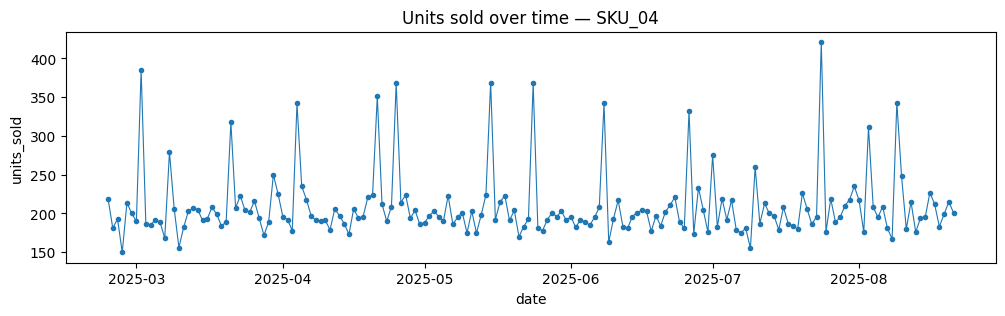

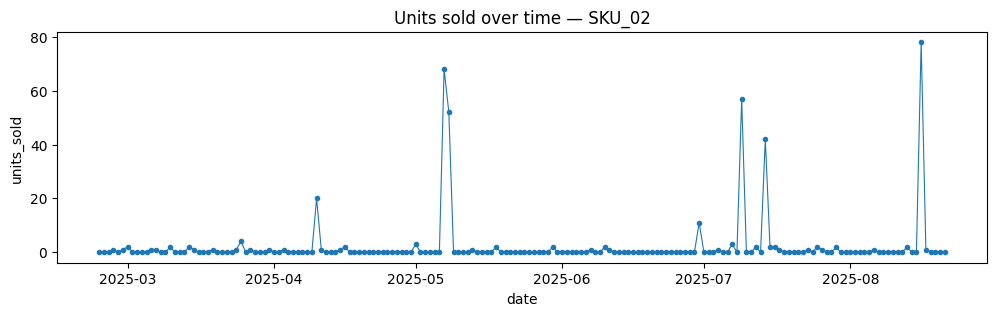

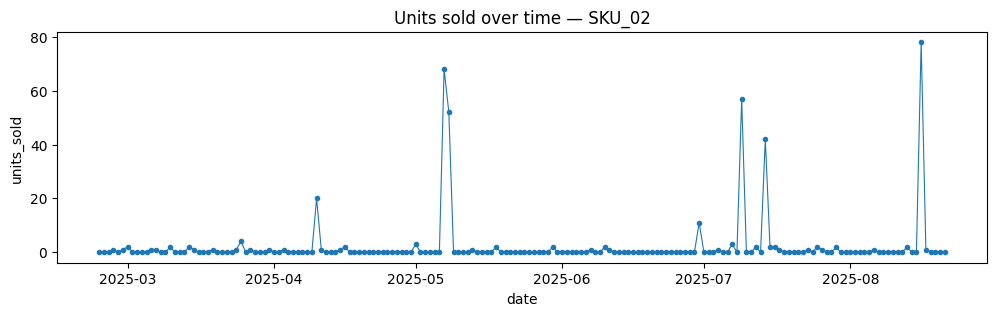

In [5]:
# Visuals: time series plot for 3 sample SKUs
import matplotlib.pyplot as plt
fast_sku = summary.sort_values('mean_daily', ascending=False)['sku_id'].iloc[0]
slow_sku = summary.sort_values('mean_daily', ascending=True)['sku_id'].iloc[0]
int_sku = 'SKU_02'
sample_skus = [fast_sku, slow_sku, int_sku]
for sku in sample_skus:
    df = sales_full[sales_full['sku_id']==sku]
    plt.figure(figsize=(12,3))
    plt.plot(df['date'], df['units_sold'], marker='.', linewidth=0.8)
    plt.title(f'Units sold over time — {sku}')
    plt.xlabel('date'); plt.ylabel('units_sold')
    plt.show()

In [6]:
# Classify SKUs
summary['bucket'] = 'medium'
summary.loc[summary['mean_daily'] >= 50, 'bucket'] = 'fast_mover'
summary.loc[summary['mean_daily'] < 20, 'bucket'] = 'slow_mover'
summary.loc[(summary['pct_zero_days'] > 40) | (summary['cv'] > 1.5), 'bucket'] = 'intermittent'
summary[['sku_id','mean_daily','std_daily','cv','pct_zero_days','bucket']]

,sku_id,mean_daily,std_daily,cv,pct_zero_days,bucket
0,SKU_01,113.622222,24.362063,0.214413,0.000000,fast_mover
1,SKU_02,2.138889,10.091627,4.718163,75.555556,intermittent
2,SKU_03,8.800000,3.523901,0.400443,0.000000,slow_mover
3,SKU_04,208.527778,44.073001,0.211353,0.000000,fast_mover
4,SKU_05,119.522222,24.552408,0.205421,0.000000,fast_mover
5,SKU_06,59.744444,12.854633,0.215160,0.000000,fast_mover
6,SKU_07,3.788889,9.943409,2.624360,72.777778,intermittent
7,SKU_08,113.877778,26.270117,0.230687,0.000000,fast_mover
8,SKU_09,152.277778,29.577104,0.194231,0.000000,fast_mover
9,SKU_10,188.805556,46.153145,0.244448,0.000000,fast_mover
